```{contents}
```
## **Data-Driven Routing in LangGraph**

**Data-Driven Routing** is a control-flow mechanism in LangGraph where **runtime data inside the shared state determines which node executes next**.
Instead of hard-coding execution paths, the graph becomes an **adaptive decision system** whose behavior emerges from data.

---

### **1. Motivation**

Traditional pipelines follow fixed paths:

```
A → B → C
```

Real intelligent systems must adapt:

```
Analyze → (Search | Compute | Ask Human | Finish)
```

The choice depends on **what the model observed**, **what tools returned**, and **what the current state contains**.

This is precisely what data-driven routing enables.

---

### **2. Conceptual Model**

```
          ┌──────────┐
          │  Router  │
          └────┬─────┘
        ┌───────┼────────┐
        ↓       ↓        ↓
     Search   Compute   Finish
```

The router examines the **state**, not the code structure.

---

### **3. How Routing Works in LangGraph**

Routing is implemented using **conditional edges** with a **decision function**.

### Core API

```python
builder.add_conditional_edges(
    "router_node",
    routing_function,
    {
        "search": "search_node",
        "compute": "compute_node",
        "finish": END
    }
)
```

The routing function **reads state** and returns a **label**.

---

### **4. Minimal Working Example**

### State

```python
class State(TypedDict):
    question: str
    needs_search: bool
    answer: str
```

### Router Function

```python
def route(state):
    if state["needs_search"]:
        return "search"
    return "finish"
```

### Graph Construction

```python
builder = StateGraph(State)

builder.add_node("router", lambda s: s)
builder.add_node("search", search_node)
builder.add_node("finish", answer_node)

builder.set_entry_point("router")

builder.add_conditional_edges("router", route, {
    "search": "search",
    "finish": "finish"
})

builder.add_edge("search", "finish")
```

**Behavior:**
The same graph dynamically chooses its path at runtime.

---

### **5. Common Routing Signals**

| Signal         | Example              |
| -------------- | -------------------- |
| LLM confidence | low → search         |
| Tool failure   | retry                |
| User intent    | question vs command  |
| Step count     | continue vs stop     |
| Quality score  | revise               |
| Cost budget    | choose cheaper model |
| Safety score   | escalate to human    |

---

### **6. Advanced Pattern: ReAct Routing**

```python
class State(TypedDict):
    thought: str
    action: str
    observation: str
    done: bool
```

```python
def react_router(state):
    if state["done"]:
        return END
    if state["action"] == "search":
        return "search"
    if state["action"] == "calculate":
        return "compute"
    return "reflect"
```

This enables **autonomous reasoning loops**.

---

### **7. Production Variants**

| Variant            | Purpose                  |
| ------------------ | ------------------------ |
| Rule-based routing | deterministic control    |
| LLM-based routing  | flexible decision making |
| Hybrid routing     | LLM + rules              |
| Cost-aware routing | minimize spend           |
| Safety routing     | enforce policy           |
| Load-aware routing | performance scaling      |

---

### **8. Why Data-Driven Routing Matters**

| Without Routing | With Routing            |
| --------------- | ----------------------- |
| Rigid pipelines | Adaptive workflows      |
| Manual design   | Emergent behavior       |
| Low robustness  | Fault-tolerant          |
| Hard to scale   | Production-ready agents |

---

### **9. Mental Model**

LangGraph with data-driven routing behaves like a **runtime decision engine**:

> **State → Decision → Path → State → Decision → ...**

This is the foundation of **agents, planners, self-correcting systems, and autonomous workflows**.


### Demonstration

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

# ------------------ State Definition ------------------

class State(TypedDict):
    question: str
    needs_search: bool
    answer: str

# ------------------ Nodes ------------------

def router(state: State):
    return state

def search_node(state: State):
    return {"answer": "Found answer from search."}

def answer_node(state: State):
    return {"answer": "Answered directly without search."}

# ------------------ Routing Logic ------------------

def route(state: State):
    if state["needs_search"]:
        return "search"
    return "finish"

# ------------------ Graph ------------------

builder = StateGraph(State)

builder.add_node("router", router)
builder.add_node("search", search_node)
builder.add_node("finish", answer_node)

builder.set_entry_point("router")

builder.add_conditional_edges(
    "router",
    route,
    {
        "search": "search",
        "finish": "finish"
    }
)

builder.add_edge("search", "finish")

graph = builder.compile()

# ------------------ Run ------------------

print("\nCase 1: Needs Search")
print(graph.invoke({"question": "What is LangGraph?", "needs_search": True, "answer": ""}))

print("\nCase 2: No Search Needed")
print(graph.invoke({"question": "2+2?", "needs_search": False, "answer": ""}))



Case 1: Needs Search
{'question': 'What is LangGraph?', 'needs_search': True, 'answer': 'Answered directly without search.'}

Case 2: No Search Needed
{'question': '2+2?', 'needs_search': False, 'answer': 'Answered directly without search.'}


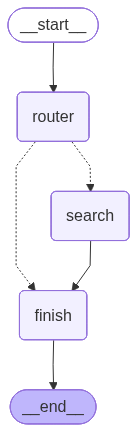

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())